### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

/home/paul/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# For now set a small population for Leeds (down by a factor of 20):

#### TODO: delete this box

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population'] // 20

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                            PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-17 10:55:28.926 INFO     Building a set of 15862 households from which to build a population
2021-05-17 10:55:33.352 INFO     15607 households of mean size 2.54
2021-05-17 10:55:33.538 INFO     8385 buildings of mean size 4.73
2021-05-17 10:55:34.893 INFO     232 classrooms of mean size 13.02
2021-05-17 10:55:34.906 INFO     3 care_homes of mean size 95.33
2021-05-17 10:55:34.935 INFO     4675 workplaces of mean size 5.65
2021-05-17 10:55:35.056 INFO     66.0% of workplaces closed by lockdown, leaving 1601 open, of average Income Decile 4.96 (and st dev 3.14).
2021-05-17 10:55:35.066 INFO     66.0% of classrooms closed by lockdown, leaving 85 open, of average Income Decile 4.52 (and st dev 3.16).
2021-05-17 10:55:35.068 INFO     Adding 17296 permanent contact groups
2021-05-17 10:55:35.068 INFO     Adding 0 ephemeral contact pairs
2021-05-17 10:55:35.279 INFO     Adding 11363 contacts each within one of the 8385 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid
from codit.immunity import ImmuneResponse

kent_variant = Covid(variant=ImmuneResponse.B_1_1_7_INFECTION)
indian_variant = Covid(variant=ImmuneResponse.B_1_617_2_INFECTION)

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()

2021-05-17 10:55:36.737 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0184
2021-05-17 10:55:47.292 INFO     Day 30, prop infected is 0.10, prop infectious is 0.0147


### Run the simulation for January and February

2021-05-17 10:55:49.043 INFO     Day 1, prop infected is 0.10, prop infectious is 0.0144
2021-05-17 10:56:08.273 INFO     Day 51, prop infected is 0.14, prop infectious is 0.0021
2021-05-17 10:56:11.244 INFO     Day 60, prop infected is 0.14, prop infectious is 0.0019
2021-05-17 10:56:11.421 INFO      Realized R0 of early infections is 0.89
2021-05-17 10:56:11.422 INFO      14.4 percent of the population was infected during the epidemic


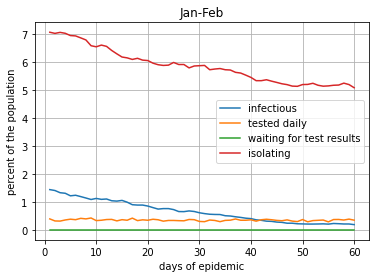

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-17 10:56:11.746 INFO     66.0% of workplaces closed by lockdown, leaving 1636 open, of average Income Decile 4.90 (and st dev 3.15).
2021-05-17 10:56:11.757 INFO     0.0% of classrooms closed by lockdown, leaving 187 open, of average Income Decile 4.77 (and st dev 3.13).
2021-05-17 10:56:11.759 INFO     Adding 17433 permanent contact groups
2021-05-17 10:56:11.768 INFO     Adding 5948 ephemeral contact pairs
2021-05-17 10:56:11.817 INFO     Adding 11361 contacts each within one of the 8385 buildings (contact density of 0.75)


2021-05-17 10:56:13.629 INFO     Day 1, prop infected is 0.14, prop infectious is 0.0018
2021-05-17 10:56:23.520 INFO     Day 30, prop infected is 0.15, prop infectious is 0.0011
2021-05-17 10:56:23.675 INFO      Realized R0 of early infections is 1.04
2021-05-17 10:56:23.676 INFO      14.9 percent of the population was infected during the epidemic


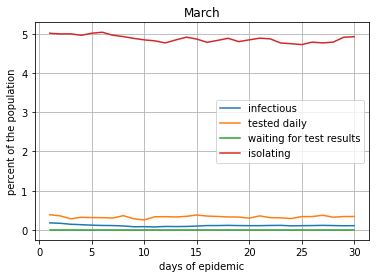

In [10]:
o_March = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [11]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

pop.seed_infections(10, indian_variant)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-17 10:56:24.000 INFO     50.0% of workplaces closed by lockdown, leaving 2454 open, of average Income Decile 5.00 (and st dev 3.15).
2021-05-17 10:56:24.012 INFO     0.0% of classrooms closed by lockdown, leaving 186 open, of average Income Decile 4.77 (and st dev 3.13).
2021-05-17 10:56:24.014 INFO     Adding 18250 permanent contact groups
2021-05-17 10:56:24.024 INFO     Adding 7931 ephemeral contact pairs
2021-05-17 10:56:24.073 INFO     Adding 11320 contacts each within one of the 8385 buildings (contact density of 0.75)


2021-05-17 10:56:26.051 INFO     Day 1, prop infected is 0.15, prop infectious is 0.0013
2021-05-17 10:56:36.203 INFO     Day 30, prop infected is 0.15, prop infectious is 0.0009
2021-05-17 10:56:36.358 INFO      Realized R0 of early infections is 0.94
2021-05-17 10:56:36.359 INFO      15.4 percent of the population was infected during the epidemic


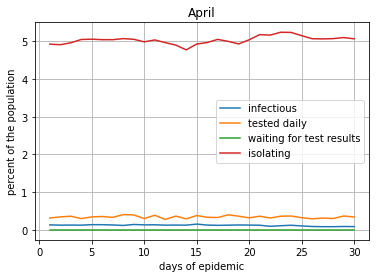

In [12]:
o_April = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-17 10:56:36.697 INFO     33.0% of workplaces closed by lockdown, leaving 3063 open, of average Income Decile 5.00 (and st dev 3.13).
2021-05-17 10:56:36.709 INFO     0.0% of classrooms closed by lockdown, leaving 196 open, of average Income Decile 4.89 (and st dev 3.14).
2021-05-17 10:56:36.710 INFO     Adding 18869 permanent contact groups
2021-05-17 10:56:36.751 INFO     Adding 9914 ephemeral contact pairs
2021-05-17 10:56:36.798 INFO     Adding 11409 contacts each within one of the 8385 buildings (contact density of 0.75)


### Surge Vaccinations all people over 16?

In [14]:
# for p in pop.people:
#     if p.age > 16:
#         p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-17 10:56:38.870 INFO     Day 1, prop infected is 0.15, prop infectious is 0.0009
2021-05-17 10:56:48.690 INFO     Day 30, prop infected is 0.16, prop infectious is 0.0004
2021-05-17 10:56:48.840 INFO      Realized R0 of early infections is 0.77
2021-05-17 10:56:48.840 INFO      15.7 percent of the population was infected during the epidemic


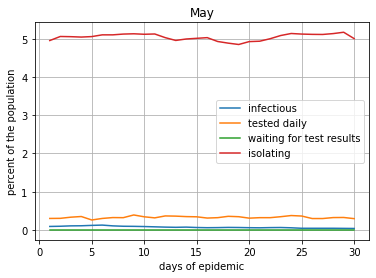

In [15]:
o_May = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")